This is a training of the model on numerical data only. I find the best possible value of alpha by computing a 5-fold Cross Validation for every possible value of alpha in range(0,40000,1000) and selecting the one that is the closest to maximizing the R2 score and minimizing the RMSE score computed by each cycle of 5_fold CV

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, validation_curve, learning_curve, cross_validate
from category_encoders import TargetEncoder

In [2]:
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
class My_Ridge :
    def __init__(self,alpha) :
        self.alpha = alpha
        self.coefficients = None

    def fit(self, X, y):
        if "intercept" not in X:
            X.insert(0,"intercept",1, True)
    
        n_feat= X.shape[1]
        I=np.eye(n_feat)
        I[0][0]=0
    
        A = np.dot(X.T, X) + self.alpha * I
        b = np.dot(X.T, y)
        self.coefficients = np.dot(np.linalg.inv(A),b)

    def predict(self, X):
        if "intercept" not in X:
            X.insert(0,"intercept",1, True)
        return np.dot(X,self.coefficients)
    
    def r2score(self,Y_pred, Y_act):
        return r2_score(Y_act,Y_pred)
    
    def mse_score(self,Y_pred, Y_act):
        return mean_squared_error(Y_act,Y_pred,squared=False)

In [4]:
spotify = pd.read_csv("dataset.csv")

In [5]:
spotify=spotify.drop(columns = "Unnamed: 0")
spotify=spotify.drop(columns = "album_name")
spotify=spotify.drop(columns = "track_name")
spotify=spotify.drop(columns = "track_id")
cor = spotify.corr()

In [6]:
cor_target= abs(cor["popularity"])
relevant_feat = cor_target[cor_target > 0.02]
relevant_feat

popularity          1.000000
explicit            0.044082
danceability        0.035448
loudness            0.050423
speechiness         0.044927
acousticness        0.025472
instrumentalness    0.095139
valence             0.040534
time_signature      0.031073
Name: popularity, dtype: float64

In [7]:
predictors =["danceability","loudness","speechiness","instrumentalness","valence","time_signature"]

In [8]:
spotify=spotify.drop(columns = "acousticness")
spotify=spotify.drop(columns = "tempo")
spotify=spotify.drop(columns = "duration_ms")
spotify=spotify.drop(columns = "energy")
spotify=spotify.drop(columns = "key")
spotify=spotify.drop(columns = "mode")
spotify=spotify.drop(columns = "liveness")
spotify

,artists,popularity,explicit,danceability,loudness,speechiness,instrumentalness,valence,time_signature,track_genre
0,Gen Hoshino,73,False,0.676,-6.746,0.1430,0.000001,0.7150,4,acoustic
1,Ben Woodward,55,False,0.420,-17.235,0.0763,0.000006,0.2670,4,acoustic
2,Ingrid Michaelson;ZAYN,57,False,0.438,-9.734,0.0557,0.000000,0.1200,4,acoustic
3,Kina Grannis,71,False,0.266,-18.515,0.0363,0.000071,0.1430,3,acoustic
4,Chord Overstreet,82,False,0.618,-9.681,0.0526,0.000000,0.1670,4,acoustic
...,...,...,...,...,...,...,...,...,...,...
113995,Rainy Lullaby,21,False,0.172,-16.393,0.0422,0.928000,0.0339,5,world-music
113996,Rainy Lullaby,22,False,0.174,-18.318,0.0401,0.976000,0.0350,4,world-music
113997,Cesária Evora,22,False,0.629,-10.895,0.0420,0.000000,0.7430,4,world-music
113998,Michael W. Smith,41,False,0.587,-10.889,0.0297,0.000000,0.4130,4,world-music


In [9]:
spotify_num = spotify[["popularity"] + predictors]
spotify_num

,popularity,danceability,loudness,speechiness,instrumentalness,valence,time_signature
0,73,0.676,-6.746,0.1430,0.000001,0.7150,4
1,55,0.420,-17.235,0.0763,0.000006,0.2670,4
2,57,0.438,-9.734,0.0557,0.000000,0.1200,4
3,71,0.266,-18.515,0.0363,0.000071,0.1430,3
4,82,0.618,-9.681,0.0526,0.000000,0.1670,4
...,...,...,...,...,...,...,...
113995,21,0.172,-16.393,0.0422,0.928000,0.0339,5
113996,22,0.174,-18.318,0.0401,0.976000,0.0350,4
113997,22,0.629,-10.895,0.0420,0.000000,0.7430,4
113998,41,0.587,-10.889,0.0297,0.000000,0.4130,4


In [10]:
k_Fold=KFold(n_splits=5,shuffle=True)

In [11]:
av=np.eye(40,1)
avr=np.eye(40,1)

In [12]:
i=0
for alphas in range(0,40000,1000): #I cycle on the alpha to find the one that gives us the best scores
    average_rscore=0.0
    average_msescore=0.0
    ridge = My_Ridge(alpha=alphas)
    for train_index, test_index in k_Fold.split(spotify): #cross validation
        train,test = (spotify_num.T[train_index]).T, (spotify_num.T[test_index]).T
    
        train=train.dropna(axis=0)
        test=test.dropna(axis=0)
    
        y = train["popularity"].copy() #I save the labels vector
        yt=(np.array([y])).T
        yt=yt.astype(np.int64)
    
        X = (train.drop(columns= 'popularity'))
        X_test=(test.drop(columns= 'popularity'))
    
        x_mean=X.mean() #normalizing training and testing dataset
        x_std=X.std()
        X = (X - x_mean) / x_std
        X_test=(X_test-x_mean)/x_std
        X=X.astype(np.float64)
        X_test=X_test.astype(np.float64)
        
        ridge.fit(X,yt) 
        predictions=ridge.predict(X_test)
    
        expect= np.array(test["popularity"]) #actual testing popularity values
        expect = np.reshape(expect,(-1,1))
    
        rscore=ridge.r2score(predictions,expect) #r2 score of the prediction
        msescore=ridge.mse_score(predictions,expect) #rmse score of the prediction
        average_rscore += rscore
        average_msescore += msescore
    av[i]=average_msescore/5 #computing the average of the r2 and rmse scores on the 5 folds
    avr[i]=average_rscore/5
    i=i+1
    print(alphas)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000


[Text(0.5, 0, 'alpha/1000'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'RMSE vs alpha')]

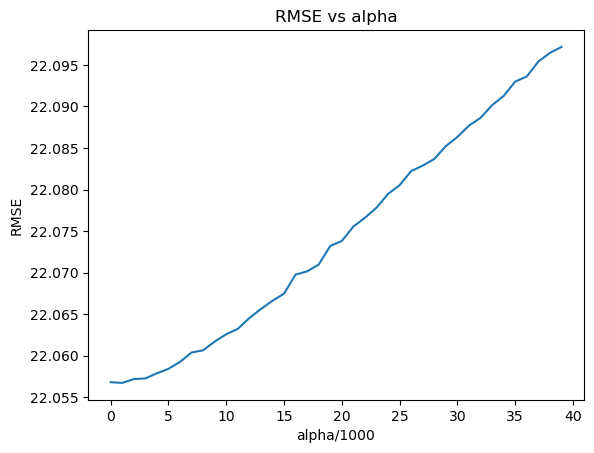

In [18]:
ax=plt.subplot()
ax.plot(av)
ax.set(xlabel='alpha/1000', ylabel='RMSE',
       title='RMSE vs alpha')

[Text(0.5, 0, 'alpha/1000'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'R2 vs alpha')]

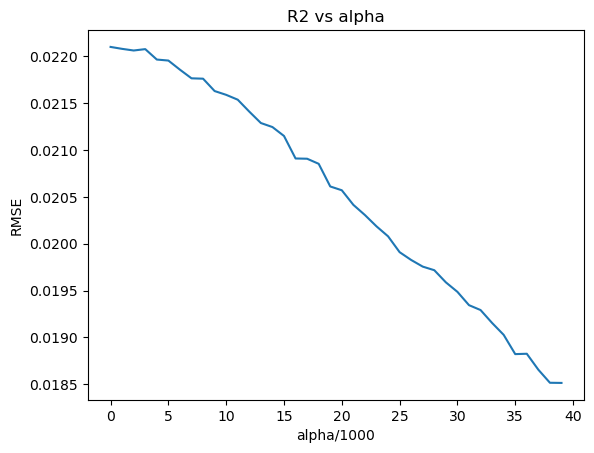

In [20]:
ax=plt.subplot()
ax.plot(avr)
ax.set(xlabel='alpha/1000', ylabel='R2',
       title='R2 vs alpha')

In [25]:
best_alpha=np.argmin(av)*1000
best_alpha

1000